In [1]:
import meep as mp
import meep.adjoint as mpa
from meep import Animate2D
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from meep.materials import Ag
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import matplotlib.colors as mcolors
from scipy.integrate import trapezoid
from matplotlib.patches import Rectangle

mp.verbosity(1)
TiO2 = mp.Medium(index=2.6)
SiO2 = mp.Medium(index=1.44)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1)

In [2]:
resolution = 100
design_region_resolution = int(resolution)

design_region_x_width  = 1   #100 nm
design_region_y_height = 1   #100 nm
design_region_z_height = 0.01  #20 nm or 10nm

pml_size = 1.0
pml_layers = [mp.PML(pml_size,direction=mp.Z)]

Sz_size = 0.6
Sx = design_region_x_width
Sy = design_region_y_height 
Sz = 2 * pml_size + design_region_z_height + Sz_size
cell_size = mp.Vector3(Sx, Sy, Sz)

wavelengths = np.array([1.55])     # wavelengths = np.array([1.5 ,1.55, 1.6])
frequencies = np.array([1 / 1.55])

nf = 1                 #3 #wavelengths Number

minimum_length = 0.01  # minimum length scale (microns)
eta_i = 0.5            # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55           # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e      # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

Source_distance = -0.2

fcen   = 1 / 1.55
width  = 0.2  
fwidth = width * fcen
source_center = mp.Vector3(0,0,Source_distance)  
source_size   = mp.Vector3(design_region_x_width, design_region_y_height, 0)
src    = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]   

Nx = int(design_region_resolution * design_region_x_width) + 1
Ny = int(design_region_resolution * design_region_y_height) + 1
Nz = 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), Air, Ag, grid_type="U_MEAN")
design_region    = mpa.DesignRegion(
            design_variables,
            volume=mp.Volume(
            center=mp.Vector3(0,0,0),
            size=mp.Vector3(design_region_x_width, design_region_y_height, design_region_z_height),
            ),
)

def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_x_width,
        design_region_y_height,
        design_region_resolution,
    )
    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)
    projected_field = (npa.fliplr(projected_field) + projected_field) / 2
    projected_field = (npa.flipud(projected_field) + projected_field) / 2  # left-right symmetry    
    
    return projected_field.flatten()


geometry = [mp.Block(center=design_region.center, size=design_region.size, material=design_variables)]

kpoint = mp.Vector3()
sim = mp.Simulation(
    cell_size        = cell_size,
    boundary_layers  = pml_layers,
    geometry         = geometry,
    sources          = source,
    default_material = Air,
    k_point          = kpoint,
    symmetries       = [mp.Mirror(direction=mp.X)],
    resolution       = resolution,
    extra_materials  = [Ag],       # Introducing metal complex terms
)
#---------------------------------------------------------------------------------------------------#


#-----------------[4]---------------------------------#
monitor_position   = mp.Vector3(0, 0, 0)       # Focus position
monitor_size       = mp.Vector3(0.01,0.01,0.01)     # Focus Size//////0.11
FourierFields_x    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ex,yee_grid=True)
FourierFields_y    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ey,yee_grid=True)
FourierFields_z    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list            = [FourierFields_x,FourierFields_y,FourierFields_z]


def J(fields_x,fields_y,fields_z):
    ET_x = npa.abs(fields_x) ** 2
    ET_y = npa.abs(fields_y) ** 2
    ET_z = npa.abs(fields_z) ** 2
    ET = npa.sqrt( npa.mean(ET_x) + npa.mean(ET_y) + npa.mean(ET_z) )  
    return ET


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decimation_factor = 1 ,           # KEY BUG!!
    maximum_run_time=50,
)

In [3]:
evaluation_history = np.load('Post_evaluation_history.npy')
evaluation_history_emp = np.load('FOM_ET_empty.npy')
beta_A  = np.load("Post_beta_scale_array.npy")
eta_A   = np.load("Post_eta_i_array.npy")
cur_A   = np.load("Post_cur_beta_array.npy")
x_A     = np.load("Post_x_array.npy")

x_180   = np.load("Post_v_array180.npy")
cur_180 = np.load("Post_cur_beta_array180.npy")
eta_180 = np.load("Post_eta_i_array180.npy") 
beta_180= np.load("Post_beta_scale_array180.npy") 

print(np.mean(x_180-x_A)  )
print(eta_180-eta_A   )
print(cur_180-cur_A  )
print(beta_180-beta_180  )

3.000986932755171e-07
0.0
-8192
0


FOM_FINAL = 21.22948133318108
FOM_FINAL = 58.01998227147954


<Figure size 640x480 with 0 Axes>

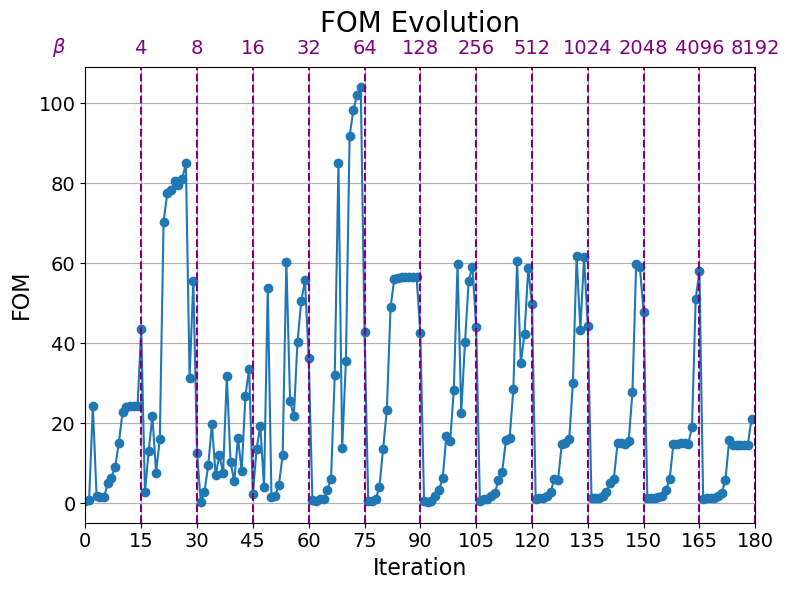

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 尺寸與字體大小設定 =====
FIGSIZE        = (8, 6)
TICK_FONTSIZE  = 14   # 座標軸刻度字級
LABEL_FONTSIZE = 16   # x/y 標籤字級
TITLE_FONTSIZE = 20   # 標題字級
BETA_FONTSIZE  = 14   # β 文字字級
ANNOT_FONTSIZE = 14   # β=4,8,16... 標註字級

# ===== 資料處理 =====
plt.figure()
evaluation_history_Correction = evaluation_history / evaluation_history_emp
print("FOM_FINAL =", evaluation_history_Correction[-1])
print("FOM_FINAL =", evaluation_history_Correction[165])

# ===== 繪圖（面向物件 API，比較好控管字型）=====
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(evaluation_history_Correction, "o-")

# === x 軸以 15 為單位 ===
block = 15
N = len(evaluation_history_Correction)
last_index = N - 1
max_tick = int(np.ceil(last_index / block)) * block  # 0, 15, 30, ...到最接近的整數倍
ax.set_xticks(np.arange(0, max_tick + 1, block))
ax.set_xlim(0, max(last_index, max_tick))
# （可選）小刻度每 5：
# ax.set_xticks(np.arange(0, max_tick + 1, 5), minor=True)

# β 區段線與標註（依資料長度自動）
value = 4
for x_pos in range(block, max_tick + 1, block):
    ax.axvline(x=x_pos, color='purple', linestyle='--')
    ax.text(
        x_pos, 1.02, f"{value}",
        color='purple', ha='center', va='bottom', fontsize=ANNOT_FONTSIZE,
        transform=ax.get_xaxis_transform(), clip_on=False
    )
    value *= 2

ax.grid(True)

# 標題與座標軸標籤字體大小（維持你的設定）
ax.set_title("FOM Evolution", fontsize=TITLE_FONTSIZE, pad=25)
ax.set_xlabel("Iteration", fontsize=LABEL_FONTSIZE)
ax.set_ylabel("FOM", fontsize=LABEL_FONTSIZE)

# 座標軸刻度字體大小（維持你的設定）
ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)

# β 文字：用座標軸百分比座標，固定在左上方（維持你的設定）
ax.text(-0.05, 1.03, r'$\beta$', color='purple', fontsize=BETA_FONTSIZE,
        transform=ax.transAxes)

plt.tight_layout()
plt.show()
plt.close()


FOM_FINAL = 21.22948133318108
FOM_FINAL = 58.01998227147954


<Figure size 640x480 with 0 Axes>

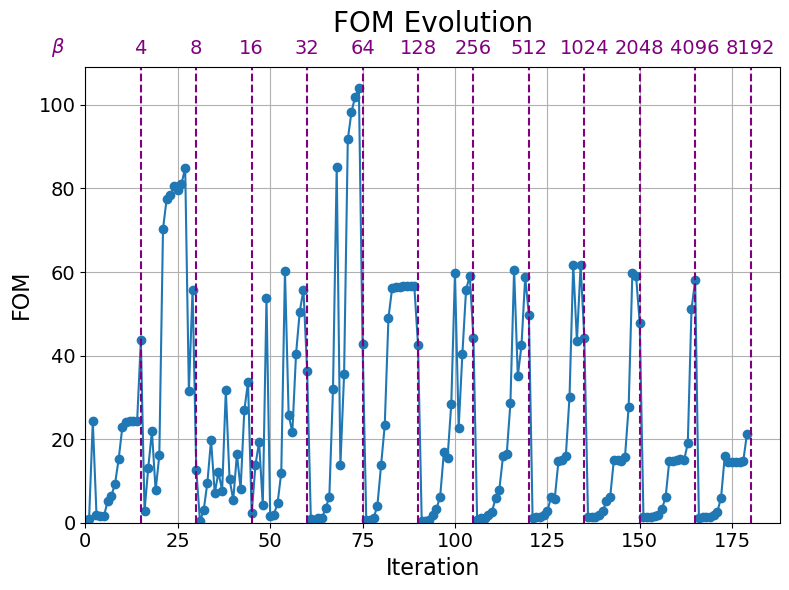

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 尺寸與字體大小設定 =====
FIGSIZE        = (8, 6)
TICK_FONTSIZE  = 14   # 座標軸刻度字級
LABEL_FONTSIZE = 16   # x/y 標籤字級
TITLE_FONTSIZE = 20   # 標題字級
BETA_FONTSIZE  = 14   # β 文字字級
ANNOT_FONTSIZE = 14   # β=4,8,16... 標註字級

# ===== 資料處理 =====
plt.figure()
evaluation_history_Correction = evaluation_history / evaluation_history_emp
print("FOM_FINAL =", evaluation_history_Correction[-1])
print("FOM_FINAL =", evaluation_history_Correction[165])

# ===== 繪圖（面向物件 API，比較好控管字型）=====
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(evaluation_history_Correction, "o-")

value = 4
for i in range(1, 13):
    x_pos = 15 * i
    ax.axvline(x=x_pos, color='purple', linestyle='--')

    # 把數字畫在 x 軸上方一點點（使用 x 軸的 transform）
    ax.text(
        x_pos, 1.02, f"{value}",
        color='purple', ha='center', va='bottom', fontsize=ANNOT_FONTSIZE,
        transform=ax.get_xaxis_transform(), clip_on=False
    )
    value *= 2

ax.grid(True)

# 軸範圍
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# 標題與座標軸標籤字體大小
ax.set_title("FOM Evolution", fontsize=TITLE_FONTSIZE, pad=25)
ax.set_xlabel("Iteration", fontsize=LABEL_FONTSIZE)
ax.set_ylabel("FOM", fontsize=LABEL_FONTSIZE)

# 座標軸刻度字體大小
ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)

# β 文字：用座標軸百分比座標，固定在左上方
ax.text(-0.05, 1.03, r'$\beta$', color='purple', fontsize=BETA_FONTSIZE,
        transform=ax.transAxes)

plt.tight_layout()
plt.show()
plt.close()


FOM_FINAL = 21.22948133318108
FOM_FINAL = 58.01998227147954


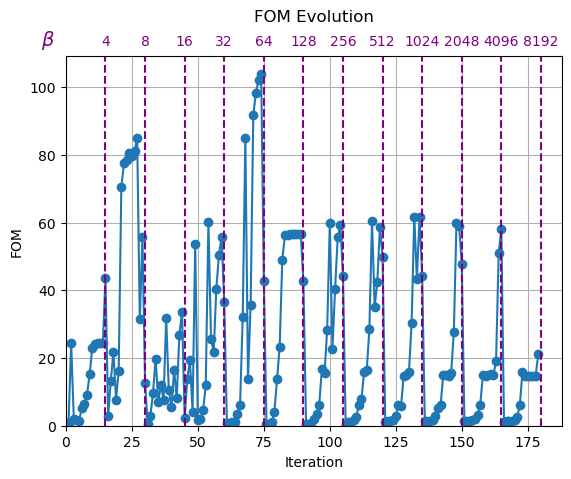

In [6]:

plt.figure()
evaluation_history_Correction = evaluation_history / evaluation_history_emp
print("FOM_FINAL =",evaluation_history_Correction[-1])
print("FOM_FINAL =",evaluation_history_Correction[165])
plt.plot(evaluation_history_Correction, "o-")

value = 4
for i in range(1, 13):
    x_pos = 15 * i
    plt.axvline(x=x_pos, color='purple', linestyle='--')

    plt.text(x_pos, 1.02,  # 大於1即可在標題之上
             f"{value}", color='purple',
             ha='center', va='bottom', fontsize=10,
             transform=plt.gca().get_xaxis_transform(),
             clip_on=False)
    value *= 2

plt.grid(True)
plt.title("FOM Evolution", pad=25)  
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.text(plt.xlim()[1]*(-0.05), plt.ylim()[1]*1.03, r'$\beta$', color='purple', fontsize=14)
plt.show()
plt.close()


FOM_FINAL = 112.43483580923937


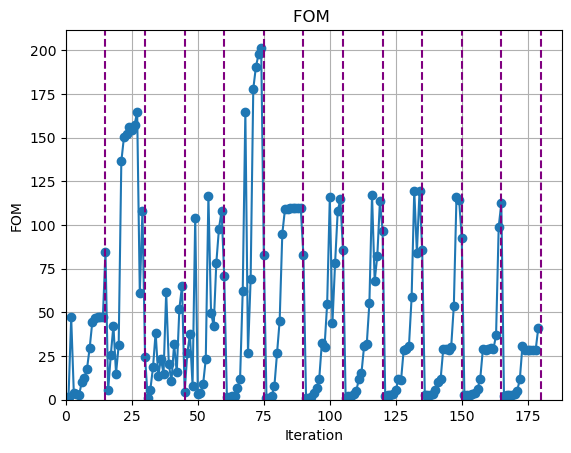

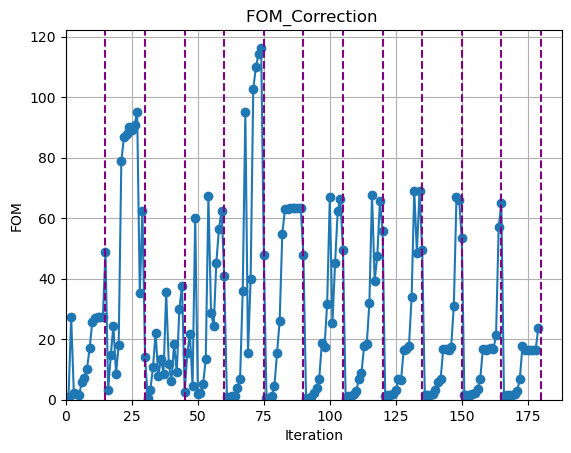

In [7]:
plt.figure()
plt.plot(evaluation_history, "o-")
print("FOM_FINAL =",evaluation_history[165])
for i in range(1,13):
    plt.axvline(x=15*i, color='purple', linestyle='--', label='x=3')
plt.grid(True)
plt.title("FOM ")
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()
plt.close()


plt.figure()
evaluation_history_Correction = evaluation_history / (np.sqrt(3))
plt.plot(evaluation_history_Correction, "o-")

for i in range(1,13):
    plt.axvline(x=15*i, color='purple', linestyle='--', label='x=3')
plt.grid(True)
plt.title("FOM_Correction ")
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()
plt.close()

     block, center = (0,0,0)
          size (1,1,0.01)
          axes (1,0,0), (0,1,0), (0,0,1)


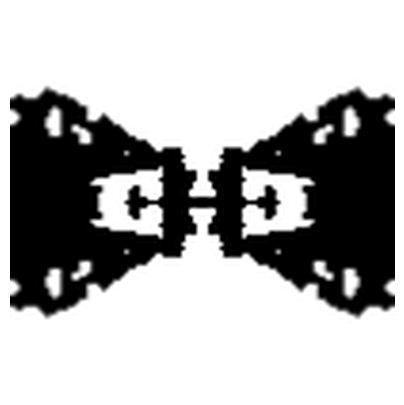

In [8]:
#opt.update_design([mapping(x_180, eta_180, cur_180 )])  # cur_beta/beta_scale is the final beta in the optimization.
opt.update_design([mapping(x_A, eta_A, cur_A )])
plt.figure(figsize=(5,5))
ax = plt.gca()
opt.plot2D(
    False,
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    output_plane = mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(design_region_x_width, design_region_y_height, 0))
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()
plt.close()

In [9]:
Ex_xz = np.load('DFT_GAS/Dft_GAS_Ex_xz.npy')
Ey_xz = np.load('DFT_GAS/Dft_GAS_Ey_xz.npy')
Ez_xz = np.load('DFT_GAS/Dft_GAS_Ez_xz.npy')
Ex_xz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ex_xz.npy')
Ey_xz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ey_xz.npy')
Ez_xz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ez_xz.npy')

Ex_yz = np.load('DFT_GAS/Dft_GAS_Ex_yz.npy')
Ey_yz = np.load('DFT_GAS/Dft_GAS_Ey_yz.npy')
Ez_yz = np.load('DFT_GAS/Dft_GAS_Ez_yz.npy')
Ex_yz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ex_yz.npy')
Ey_yz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ey_yz.npy')
Ez_yz_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ez_yz.npy')

Ex_xyz1 = np.load('DFT_GAS/Dft_GAS_Ex_xyz1.npy')
Ey_xyz1 = np.load('DFT_GAS/Dft_GAS_Ey_xyz1.npy')
Ez_xyz1 = np.load('DFT_GAS/Dft_GAS_Ez_xyz1.npy')
Ex_xyz1_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ex_xyz1.npy')
Ey_xyz1_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ey_xyz1.npy')
Ez_xyz1_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ez_xyz1.npy')

Ex_xyz0 = np.load('DFT_GAS/Dft_GAS_Ex_xyz0.npy')
Ey_xyz0 = np.load('DFT_GAS/Dft_GAS_Ey_xyz0.npy')
Ez_xyz0 = np.load('DFT_GAS/Dft_GAS_Ez_xyz0.npy')
Ex_xyz0_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ex_xyz0.npy')
Ey_xyz0_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ey_xyz0.npy')
Ez_xyz0_empty = np.load('DFT_empty_GAS/Dft_empty_GAS_Ez_xyz0.npy')

Ex_mode_volume = np.load('DFT_mode_volume/DFT_mode_volume_Ex_xyz0.npy')
Ey_mode_volume = np.load('DFT_mode_volume/DFT_mode_volume_Ey_xyz0.npy')
Ez_mode_volume = np.load('DFT_mode_volume/DFT_mode_volume_Ez_xyz0.npy')

Ex_mode_volume_emp = np.load('DFT_mode_volume_emp/DFT_mode_volume_emp_Ex_xyz0.npy')
Ey_mode_volume_emp = np.load('DFT_mode_volume_emp/DFT_mode_volume_emp_Ey_xyz0.npy')
Ez_mode_volume_emp = np.load('DFT_mode_volume_emp/DFT_mode_volume_emp_Ez_xyz0.npy')


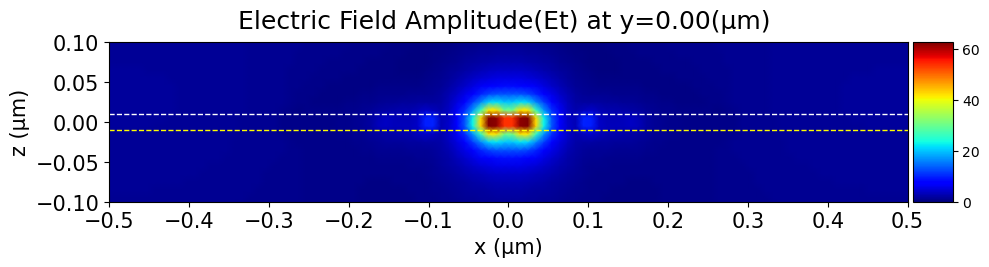

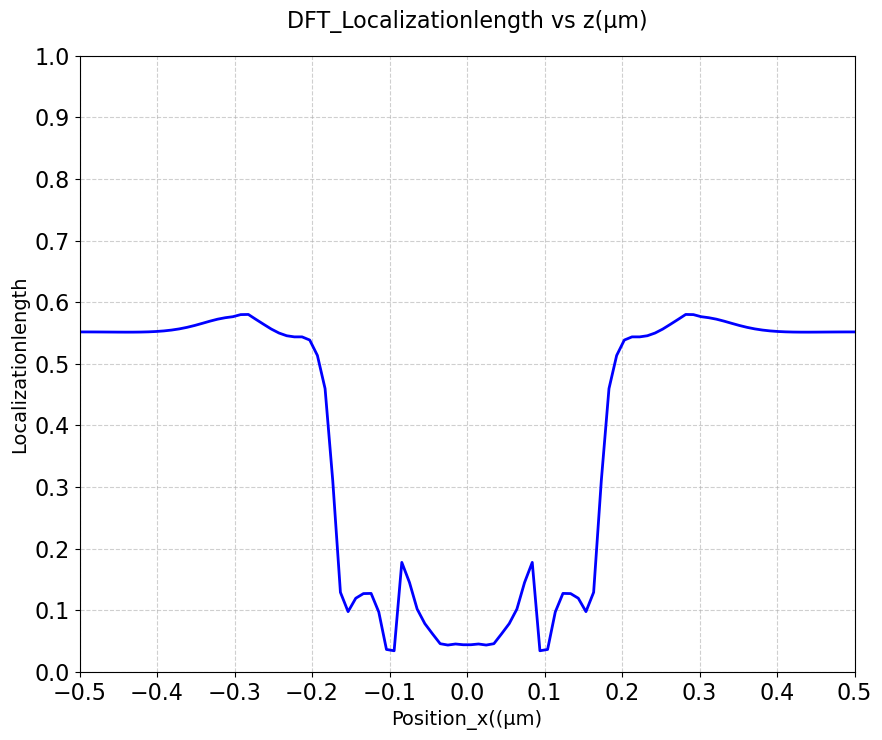

0.04380499221988141


In [10]:
amplitude_xz       = np.sqrt(np.abs(Ex_xz)**2 + np.abs(Ey_xz)**2 + np.abs(Ez_xz)**2)
amplitude_xz_log   = np.log(amplitude_xz)
amplitude_xz_sqrt  = np.sqrt(amplitude_xz) 

amplitude_xz_empty    = np.sqrt(np.abs(Ex_xz_empty)**2 + np.abs(Ey_xz_empty)**2 + np.abs(Ez_xz_empty)**2)
amplitude_xz_enhance  = amplitude_xz / amplitude_xz_empty
amplitude_xz_enhance_log  = np.log(amplitude_xz_enhance) 
amplitude_xz_enhance_sqrt = np.sqrt(amplitude_xz_enhance)

x = np.linspace(-Sx/2,Sx/2,Ey_xz.shape[0])
z = np.linspace(-(Sz-2 * pml_size)/2,(Sz-2 * pml_size)/2,Ey_xz.shape[1])





######################################################################################################
plt.figure(figsize=(10, 8))

plt.axhline(y= 0.01, color="white" , linestyle="--", linewidth=1, label="y = 0.01 μm")
plt.axhline(y=-0.01, color="yellow", linestyle="--", linewidth=1, label="y = -0.01 μm")

cmap_green = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 0, 0), (0, 0, 1)]  # blue
)
plt.pcolormesh(
        x,
        z,
        np.transpose(amplitude_xz_enhance),
        cmap="jet",
        shading="gouraud",
        vmin=0,
        vmax=np.amax(amplitude_xz_enhance),
    )
plt.gca().set_aspect("equal")
plt.title("Electric Field Amplitude(Et) at y=0.00(μm) ", fontsize=18, pad=10)
plt.xlabel("x (μm)", fontsize=15)
plt.ylabel("z (μm)", fontsize=15)
plt.xticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
plt.ylim(-0.1, 0.1)
plt.yticks(np.arange(-0.1, 0.1 + 0.000001, 0.05), fontsize=15)
# ensure that the height of the colobar matches that of the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()
plt.show()
plt.close()

################################################################################################################
Et_xyz0_4 = np.abs(amplitude_xz  )**4
Et_xyz0_2 = np.abs(amplitude_xz  )**2


x = np.linspace(-Sx/2, Sx/2,Et_xyz0_4.shape[0])
z = np.linspace(-(Sz-2*pml_size)/2, (Sz-2*pml_size)/2,Et_xyz0_4.shape[1])

L = []
L_1 = []
L_2 = []
for i in range (Et_xyz0_4.shape[0]):
    Ey_4_I = trapezoid(Et_xyz0_4[i,:],x=z)
    L_1.append(Ey_4_I)

for i in range (Et_xyz0_2.shape[0]):
    Ey_2_I = trapezoid(Et_xyz0_2[i,:],x=z)
    Ey_2_I_2 = Ey_2_I**2
    L_2.append(Ey_2_I_2)

L_1 = np.array(L_1)
L_2 = np.array(L_2)
L = np.array(L)
L =  L_2/L_1


plt.figure(figsize=(10, 8))  # 調整圖的大小
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.title("DFT_Localizationlength vs z(μm)", fontsize=16, pad=20)
plt.grid(True, linestyle="--", alpha=0.6)  # 增加網格線
plt.plot(x, L, color="blue", linewidth=2, label="Mean Ey over y-axis")
plt.xlim(-0.5,0.5)
plt.tick_params(axis='x',labelsize=16)
plt.xticks(np.arange(-0.5,0.5+0.000001 , 0.1))
plt.ylim(0,1)
plt.tick_params(axis='y',labelsize=16)
plt.yticks(np.arange(0,1+0.000001 , 0.1))
plt.xlabel("Position_x((μm)" ,fontsize=14)
plt.ylabel("Localizationlength",fontsize=14)
plt.show()
plt.close()

print(L[51])






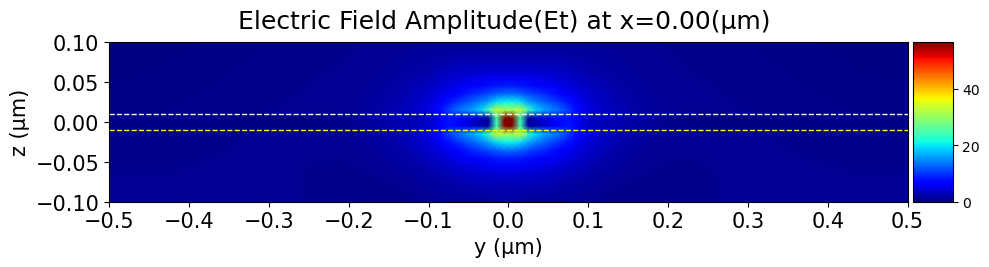

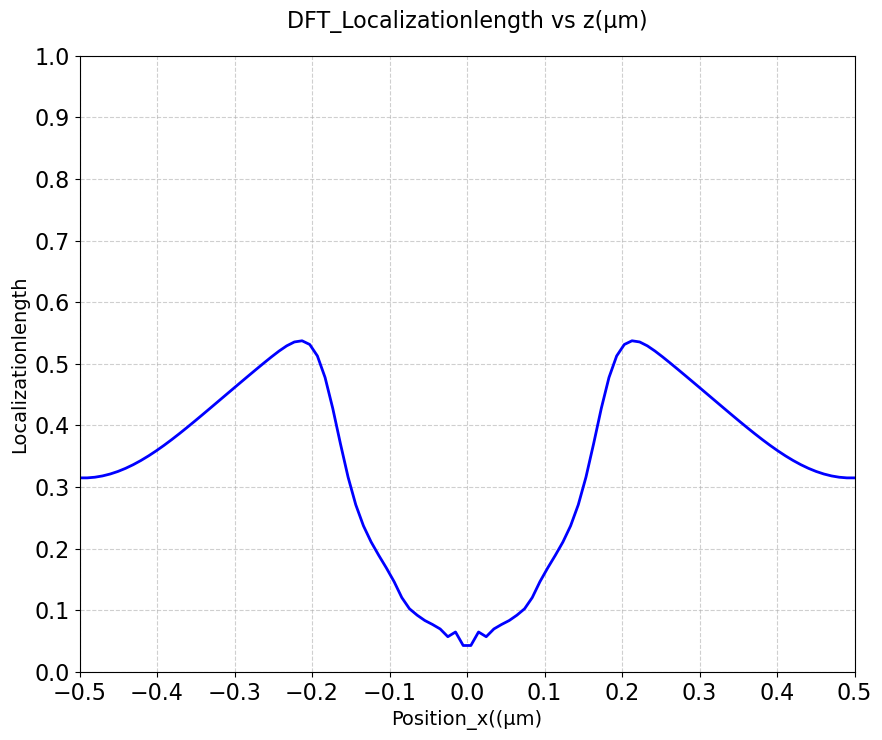

In [11]:
amplitude_yz       = np.sqrt(np.abs(Ex_yz)**2 + np.abs(Ey_yz)**2 + np.abs(Ez_yz)**2)
amplitude_yz_log   = np.log(amplitude_yz)
amplitude_yz_sqrt  = np.sqrt(amplitude_yz) 

amplitude_yz_empty    = np.sqrt(np.abs(Ex_yz_empty)**2 + np.abs(Ey_yz_empty)**2 + np.abs(Ez_yz_empty)**2)
amplitude_yz_enhance  = amplitude_yz / amplitude_yz_empty
amplitude_yz_enhance_log  = np.log(amplitude_yz_enhance) 
amplitude_yz_enhance_sqrt = np.sqrt(amplitude_yz_enhance)

x = np.linspace(-Sx/2,Sx/2,Ey_yz.shape[0])
z = np.linspace(-(Sz-2 * pml_size)/2,(Sz-2 * pml_size)/2,Ey_yz.shape[1])





######################################################################################################
plt.figure(figsize=(10, 8))

plt.axhline(y= 0.01, color="white" , linestyle="--", linewidth=1, label="y = 0.01 μm")
plt.axhline(y=-0.01, color="yellow", linestyle="--", linewidth=1, label="y = -0.01 μm")

cmap_green = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 0, 0), (0, 0, 1)]  # blue
)
plt.pcolormesh(
        x,
        z,
        np.transpose(amplitude_yz_enhance),
        cmap="jet",
        shading="gouraud",
        vmin=0,
        vmax=np.amax(amplitude_yz_enhance),
    )
plt.gca().set_aspect("equal")
plt.title("Electric Field Amplitude(Et) at x=0.00(μm) ", fontsize=18, pad=10)
plt.xlabel("y (μm)", fontsize=15)
plt.ylabel("z (μm)", fontsize=15)
plt.xticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
plt.ylim(-0.1, 0.1)
plt.yticks(np.arange(-0.1, 0.1 + 0.000001, 0.05), fontsize=15)
# ensure that the height of the colobar matches that of the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()
plt.show()
plt.close()

################################################################################################################
Et_xyz0_4 = np.abs(amplitude_yz  )**4
Et_xyz0_2 = np.abs(amplitude_yz  )**2


x = np.linspace(-Sx/2, Sx/2,Et_xyz0_4.shape[0])
z = np.linspace(-(Sz-2*pml_size)/2, (Sz-2*pml_size)/2,Et_xyz0_4.shape[1])

L = []
L_1 = []
L_2 = []
for i in range (Et_xyz0_4.shape[0]):
    Ey_4_I = trapezoid(Et_xyz0_4[i,:],x=z)
    L_1.append(Ey_4_I)

for i in range (Et_xyz0_2.shape[0]):
    Ey_2_I = trapezoid(Et_xyz0_2[i,:],x=z)
    Ey_2_I_2 = Ey_2_I**2
    L_2.append(Ey_2_I_2)

L_1 = np.array(L_1)
L_2 = np.array(L_2)
L = np.array(L)
L =  L_2/L_1


plt.figure(figsize=(10, 8))  # 調整圖的大小
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.title("DFT_Localizationlength vs z(μm)", fontsize=16, pad=20)
plt.grid(True, linestyle="--", alpha=0.6)  # 增加網格線
plt.plot(x, L, color="blue", linewidth=2, label="Mean Ey over y-axis")
plt.xlim(-0.5,0.5)
plt.tick_params(axis='x',labelsize=16)
plt.xticks(np.arange(-0.5,0.5+0.000001 , 0.1))
plt.ylim(0,1)
plt.tick_params(axis='y',labelsize=16)
plt.yticks(np.arange(0,1+0.000001 , 0.1))
plt.xlabel("Position_x((μm)" ,fontsize=14)
plt.ylabel("Localizationlength",fontsize=14)
plt.show()
plt.close()






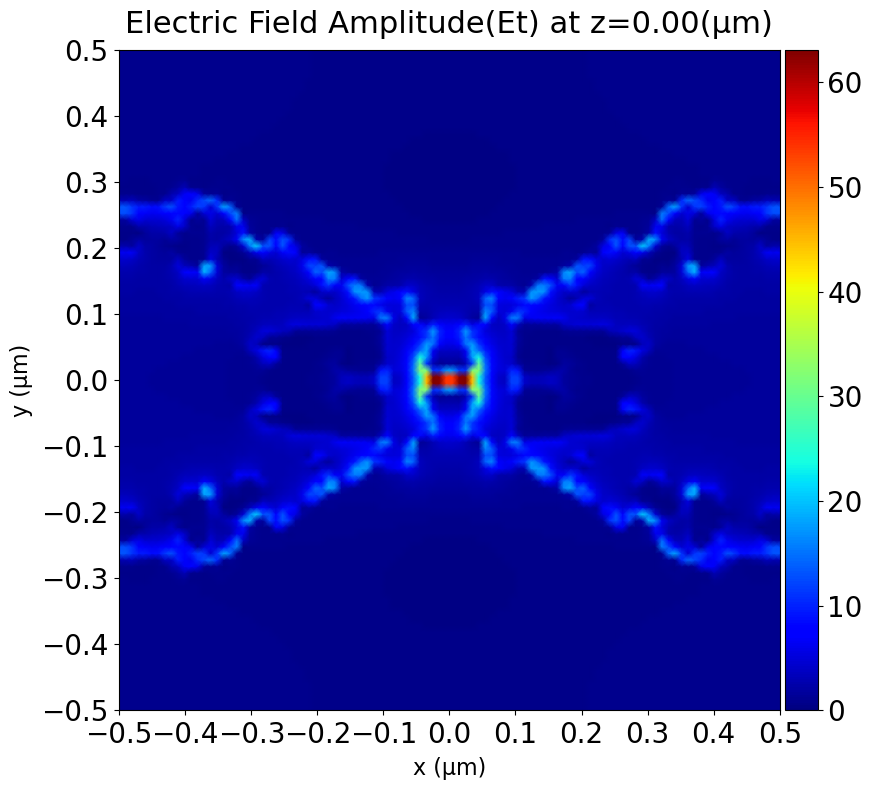

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ================== 參數（字型大小與版面） ==================
TITLE_TEXT       = "Electric Field Amplitude(Et) at z=0.00(μm)"
TITLE_SIZE       = 22     # 標題字體大小
TITLE_PAD        = 12     # 標題與圖的距離

AX_LABEL_SIZE    = 16     # 座標軸標籤字體大小
AX_LABEL_PAD     = 6      # 座標軸標籤與軸的距離

TICK_LABEL_SIZE  = 20     # 座標軸刻度字體大小
TICK_PAD         = 4      # 座標軸刻度文字與軸的距離

CBAR_TICK_SIZE   = 20     # colorbar 刻度字體大小
CBAR_LABEL       = None   # 例如 "|E| enhancement"；不需要就設 None

FIGSIZE          = (10, 8)
CMAP             = "jet"  # 你也可改 'turbo' / 'viridis' 等
VMIN             = 0.0    # 下限；若想自動就設 None
VMAX             = None   # 上限；若想用資料最大值就設 None

X_TICK_START     = -0.5   # x 刻度起點（μm）
X_TICK_STOP      =  0.5   # x 刻度終點（μm）
X_TICK_STEP      =  0.1
Y_TICK_START     = -0.5
Y_TICK_STOP      =  0.5
Y_TICK_STEP      =  0.1

# ================== 資料前處理 ==================
# 期待你已經有 Ex_xyz0, Ey_xyz0, Ez_xyz0（z=0 的切片）以及空腔對照 *_empty
# 若它們尚未存在，請先準備好；以下直接按你原本的定義計算：

amplitude_xyz0       = np.sqrt(np.abs(Ex_xyz0)**2 + np.abs(Ey_xyz0)**2 + np.abs(Ez_xyz0)**2)
amplitude_xyz0_empty = np.sqrt(np.abs(Ex_xyz0_empty)**2 + np.abs(Ey_xyz0_empty)**2 + np.abs(Ez_xyz0_empty)**2)

# 增益（避免除 0）
eps = 1e-12
amplitude_xyz0_enhance = amplitude_xyz0 / (amplitude_xyz0_empty + eps)

# 建立座標（與你原本一致）
x = np.linspace(-Sx/2, Sx/2, Ey_xyz0.shape[0])
y = np.linspace(-Sy/2, Sy/2, Ey_xyz0.shape[1])

# pcolormesh 要求 Z 和 X/Y 尺寸對應；你原本用 transpose，因此維持相同作法
Zplot = np.transpose(amplitude_xyz0_enhance)

# 決定色階範圍
vmin = VMIN if VMIN is not None else 0.0
vmax = VMAX if VMAX is not None else float(np.nanmax(amplitude_xyz0_enhance))

# ================== 繪圖 ==================
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()

pcm = ax.pcolormesh(
    x, y, Zplot,
    cmap=CMAP,
    shading="gouraud",
    vmin=vmin,
    vmax=vmax,
)

ax.set_aspect("equal")

# 標題與座標軸標籤
ax.set_title(TITLE_TEXT, fontsize=TITLE_SIZE, pad=TITLE_PAD)
ax.set_xlabel("x (μm)", fontsize=AX_LABEL_SIZE, labelpad=AX_LABEL_PAD)
ax.set_ylabel("y (μm)", fontsize=AX_LABEL_SIZE, labelpad=AX_LABEL_PAD)

# 刻度與字體大小
ax.set_xticks(np.arange(X_TICK_START, X_TICK_STOP + 1e-12, X_TICK_STEP))
ax.set_yticks(np.arange(Y_TICK_START, Y_TICK_STOP + 1e-12, Y_TICK_STEP))
ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE, pad=TICK_PAD)

# colorbar（與主圖等高）
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(pcm, cax=cax)
cbar.ax.tick_params(labelsize=CBAR_TICK_SIZE)
if CBAR_LABEL:
    cbar.set_label(CBAR_LABEL, fontsize=AX_LABEL_SIZE, labelpad=6)

plt.tight_layout()
plt.show()
plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


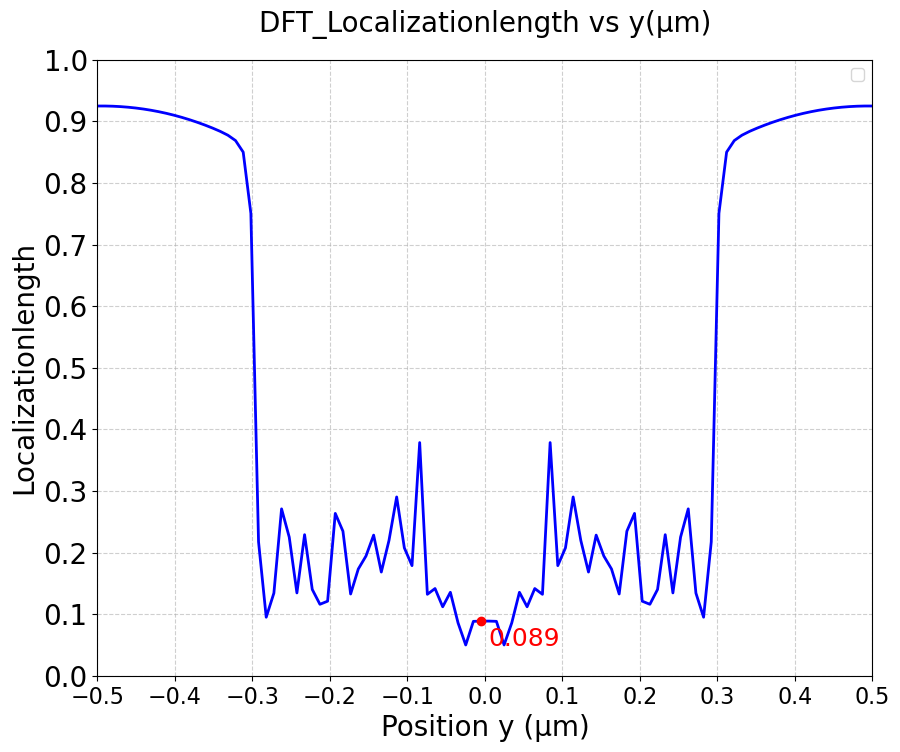

In [13]:
Et_xyz0_4 = np.abs(amplitude_xyz0 )**4
Et_xyz0_2 = np.abs(amplitude_xyz0 )**2


x = np.linspace(-Sx/2, Sx/2,Et_xyz0_4.shape[0])
y = np.linspace(-Sy/2, Sy/2,Et_xyz0_4.shape[1])

L = []
L_1 = []
L_2 = []
for i in range (Et_xyz0_4.shape[1]):
    Ey_4_I = trapezoid(Et_xyz0_4[:,i],x=x)
    L_1.append(Ey_4_I)

for i in range (Et_xyz0_2.shape[1]):
    Ey_2_I = trapezoid(Et_xyz0_2[:,i],x=x)
    Ey_2_I_2 = Ey_2_I**2
    L_2.append(Ey_2_I_2)

L_1 = np.array(L_1)
L_2 = np.array(L_2)
L = np.array(L)
L =  L_2/L_1


y_index = np.argmin(np.abs(y - 0))
y_value = y[y_index]
L_value = L[y_index]

# 繪圖
plt.figure(figsize=(10, 8))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.title("DFT_Localizationlength vs y(μm)", fontsize=20, pad=20)
plt.grid(True, linestyle="--", alpha=0.6)
plt.plot(y, L, color="blue", linewidth=2, )

# ⬇️ 只標紅點與文字（不加虛線）
plt.scatter(y_value, L_value, color='red', zorder=5)
plt.text(y_value + 0.01, L_value - 0.04, f"{L_value:.3f}", color='red', fontsize=18)

# 座標軸設定
plt.xlim(-0.5, 0.5)
plt.xticks(np.arange(-0.5, 0.5+0.000001 , 0.1), fontsize=16)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1+0.000001 , 0.1), fontsize=20)
plt.xlabel("Position y (μm)", fontsize=20)
plt.ylabel("Localizationlength", fontsize=20)

plt.legend(fontsize=12)
plt.show()
plt.close()
############################################################################







(102, 102, 62)
0.02139344262295073


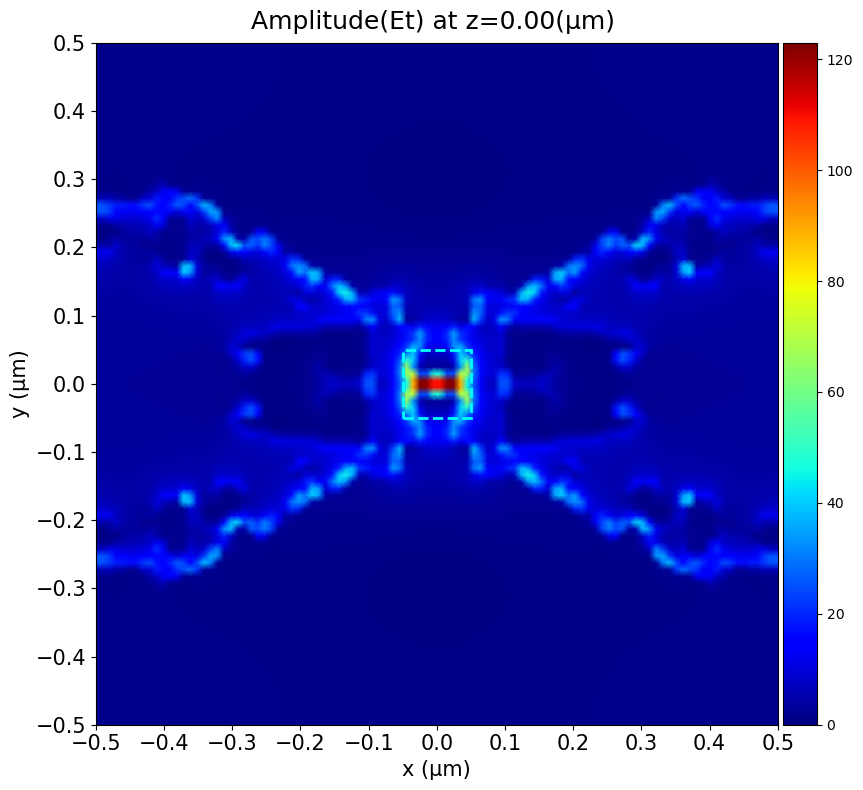

mode volume in center 0.1×0.1×0.4 μm³ region = 0.00015243880420637968 μm³


In [14]:

mode_volume  = np.sqrt(np.abs(Ex_mode_volume)**2 + np.abs(Ey_mode_volume)**2 + np.abs(Ez_mode_volume)**2)
#print(mode_volume)
mode_volume_Z0 = mode_volume[:,:,31]
#print(mode_volume_Z0)
print(mode_volume.shape)
####################################################################################################
Nz = mode_volume.shape[2]
z = np.linspace(-Sz/2, Sz/2, Nz)
print(z[31])

x = np.linspace(-Sx/2,Sx/2,mode_volume_Z0.shape[0])
y = np.linspace(-Sy/2,Sy/2,mode_volume_Z0.shape[1])





######################################################################################################
plt.figure(figsize=(10, 8))

cmap_green = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 0, 0), (0, 0, 1)]  # blue
)
plt.pcolormesh(
        x,
        y,
        np.transpose(mode_volume_Z0),
        cmap="jet",
        shading="gouraud",
        vmin=0,
        vmax=np.amax(mode_volume_Z0),
    )

x0 = 0  # 你視覺上選定的中心點
y0 = 0
width = 0.1
height = 0.1

rect = Rectangle((x0 - width/2, y0 - height/2), width, height,
                 edgecolor='cyan', facecolor='none', linewidth=2, linestyle='--')
plt.gca().add_patch(rect)


plt.gca().set_aspect("equal")
plt.title("Amplitude(Et) at z=0.00(μm) ", fontsize=18, pad=10)#fontweight='bold', pad=20)
plt.xlabel("x (μm)", fontsize=15)
plt.ylabel("y (μm)", fontsize=15)
plt.xticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
plt.ylim(-0.5, 0.5)
plt.yticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
# ensure that the height of the colobar matches that of the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()
plt.show()
plt.close()





####################################################################################################
x0 = 0  # μm
y0 = 0 # μm
# 建立實際座標軸
x = np.linspace(-0.5, 0.5, Nx)
y = np.linspace(-0.5, 0.5, Ny)
z = np.linspace(-0.3, 0.3, Nz)  # 對應 shape = 62

# 中心 ±0.05 μm 與 ±0.2 μm 範圍
#x_mask = np.logical_and(x >= x0 - 0.5, x <= x0 + 0.5)
#y_mask = np.logical_and(y >= y0 - 0.5, y <= y0 + 0.5)
#z_mask = np.logical_and(z >= -0.3, z <= 0.3)

x_mask = np.logical_and(x >= x0 - 0.05, x <= x0 + 0.05)
y_mask = np.logical_and(y >= y0 - 0.05, y <= y0 + 0.05)
z_mask = np.logical_and(z >= -0.02, z <= 0.02)
# 裁切座標與資料

x_crop = x[x_mask]
y_crop = y[y_mask]
z_crop = z[z_mask]
mv_crop = mode_volume[np.ix_(x_mask, y_mask, z_mask)]

# 計算 |E|² 與 |E|⁴
Et2 = mv_crop
Et4 = Et2**2

# 三維 trapezoidal 積分
I2 = trapezoid(trapezoid(trapezoid(Et2, x=z_crop, axis=2),
                         x=y_crop, axis=1),
               x=x_crop, axis=0)
I4 = trapezoid(trapezoid(trapezoid(Et4, x=z_crop, axis=2),
                         x=y_crop, axis=1),
               x=x_crop, axis=0)

L_3D = (I2 ** 2) / I4
print("mode volume in center 0.1×0.1×0.4 μm³ region =", L_3D, "μm³")


MAX_FIELD = 122.26344327976224
23.752102281398727
(102, 102)
104.32777670015292


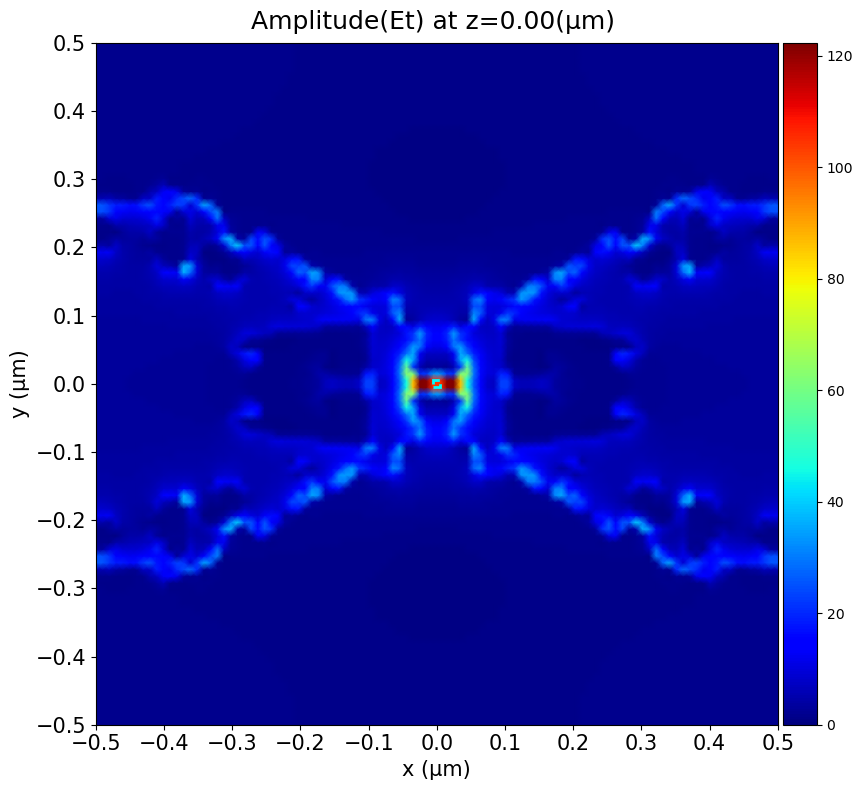

In [15]:
amplitude_xyz0       = np.sqrt(np.abs(Ex_xyz0)**2 + np.abs(Ey_xyz0)**2 + np.abs(Ez_xyz0)**2)
print("MAX_FIELD =", np.amax(amplitude_xyz0))
fom_error = evaluation_history[-1] / (np.sqrt(3))
print(fom_error)
print(amplitude_xyz0.shape)
print(amplitude_xyz0[50,50])
amplitude_xyz0_log   = np.log(amplitude_xyz0 )
amplitude_xyz0_sqrt  = np.sqrt(amplitude_xyz0 ) 

amplitude_xyz0_empty    = np.sqrt(np.abs(Ex_xyz0_empty)**2 + np.abs(Ey_xyz0_empty)**2 + np.abs(Ez_xyz0_empty)**2)
amplitude_xyz0_enhance  = amplitude_xyz0 / amplitude_xyz0_empty
amplitude_xyz0_enhance_log  = np.log(amplitude_xyz0_enhance) 
amplitude_xyz0_enhance_sqrt = np.sqrt(amplitude_xyz0_enhance)

x = np.linspace(-Sx/2,Sx/2,Ey_xyz0.shape[0])
y = np.linspace(-Sy/2,Sy/2,Ey_xyz0.shape[1])

################################################################################################################
plt.figure(figsize=(10, 8))

cmap_green = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 0, 0), (0, 0, 1)]  # blue
)
plt.pcolormesh(
        x,
        y,
        np.transpose(amplitude_xyz0  ),
        cmap="jet",
        shading="gouraud",
        vmin=0,
        vmax=np.amax(amplitude_xyz0  ),
    )

x0 = 0  # 你視覺上選定的中心點
y0 = 0
width = 0.01
height = 0.01

rect = Rectangle((x0 - width/2, y0 - height/2), width, height,
                 edgecolor='cyan', facecolor='none', linewidth=2, linestyle='--')
plt.gca().add_patch(rect)


plt.gca().set_aspect("equal")
plt.title("Amplitude(Et) at z=0.00(μm) ", fontsize=18, pad=10)#fontweight='bold', pad=20)
plt.xlabel("x (μm)", fontsize=15)
plt.ylabel("y (μm)", fontsize=15)
plt.xticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
plt.ylim(-0.5, 0.5)
plt.yticks(np.arange(-0.5, 0.5 + 0.000001, 0.1), fontsize=15)
# ensure that the height of the colobar matches that of the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.tight_layout()
plt.show()
plt.close()



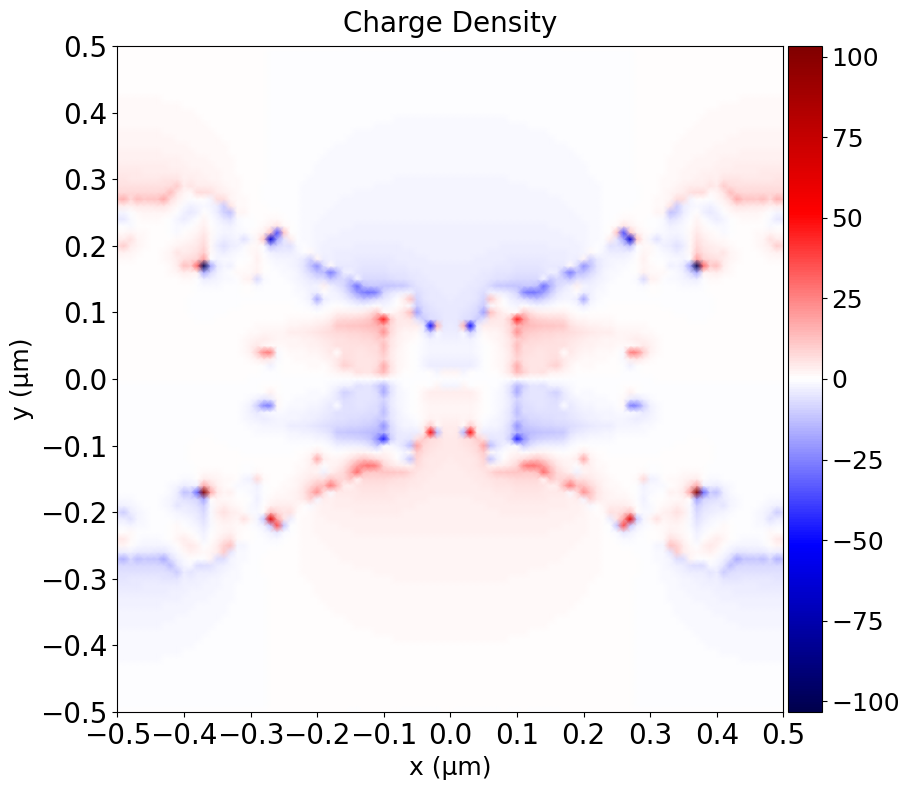

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# === 讀取資料 ===
Ez_CD_pos = np.load('DFT_charge_density/DFT_charge_density_Ez_pos.npy')
Ez_CD_neg = np.load('DFT_charge_density/DFT_charge_density_Ez_neg.npy')

# === 計算實部的「電荷密度」場 ===
Ez_CHARGE_real = np.real(Ez_CD_pos) - np.real(Ez_CD_neg)

# === 座標軸（使用你的 Sx、Sy；若未定義請自行替換）===
x = np.linspace(-Sx/2, Sx/2, Ez_CHARGE_real.shape[0])
y = np.linspace(-Sy/2, Sy/2, Ez_CHARGE_real.shape[1])

# === 色軸對稱到 0（適合 seismic/bwr）===
vmax = np.max(np.abs(Ez_CHARGE_real))
vmin = -vmax

# === 繪圖 ===
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.pcolormesh(
    x,
    y,
    np.transpose(Ez_CHARGE_real),
    cmap="seismic",
    shading="gouraud",
    vmin=vmin,
    vmax=vmax,
)

ax.set_aspect("equal")
ax.set_title("Charge Density", fontsize=20, pad=10)
ax.set_xlabel("x (μm)", fontsize=18)
ax.set_ylabel("y (μm)", fontsize=18)
ax.set_ylim(-0.5, 0.5)
ax.set_xticks(np.arange(-0.5, 0.5 + 1e-6, 0.1))
ax.set_yticks(np.arange(-0.5, 0.5 + 1e-6, 0.1))
ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE, pad=TICK_PAD)
#ax.tick_params(axis='both', labelsize=30)

# === colorbar，並更改字體大小 ===
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)

# 調整 colorbar 字體大小（刻度與標籤）
cbar.ax.tick_params(labelsize=18)                 # 刻度字級
# 若有科學記號的 offset（例如 ×1e-3），也調整其字級：
cbar.ax.yaxis.get_offset_text().set_fontsize(30)

plt.tight_layout()
plt.show()
plt.close()
